# Searching for strips and performing simple coregistration for a DEM difference

In [1]:
import os

import pdemtools as pdt


As well as `pdemtools`, we will also make use of `matplotlib` to plot our results in this notebook.

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

# %matplotlib widget


We will also need to provide the local location of the ArcticDEM strip index and ArcticDEM bedmachine product:

In [3]:

index_fpath = '/Users/tom/Library/CloudStorage/OneDrive-DurhamUniversity/data/arcticdem_metadata/ArcticDEM_Strip_Index_s2s041.parquet'
bm_fpath = '/Users/tom/Library/CloudStorage/OneDrive-DurhamUniversity/data/bedmachine_5/BedMachineGreenland-v5.nc'


# Searching for strips

For the example here, let's example recent surface elevation change across KIV Steenstrups Nordre Bræ (where we know [significant change occurred between 2016 and 2021](https://doi.org/10.1038/s41467-023-37764-7)).

Let's set an appropriate bounding box (in EPSG:3413 / Polar Stereographic North), and set further filtering choices to limit our options to high-quality, summer scenes that cover at least 70% of the bounding box:

In [4]:

bounds = (459000, -2539000, 473000, -2528000)

gdf = pdt.search(
    index_fpath, 
    bounds, 
    dates = '20170101/20221231',
    months = [6,7,8,9],
    years = [2017,2021],
    baseline_max_days = 1,
    sensors=['WV03', 'WV02', 'WV01'],
    accuracy=[0, 2],
    min_aoi_frac = 0.7,
)

gdf = gdf.sort_values('acqdate1')

print(f'{len(gdf)} strips found')


5 strips found


The `pdt.search()` function returns a geopandas geodataframe, which we can visualise as with any other dataframe:

In [5]:
gdf[['dem_id', 'acqdate1', 'acqdate2']]

,dem_id,acqdate1,acqdate2
83475,SETSM_s2s041_WV01_20170607_1020010063D4CE00_10...,2017-06-07,2017-06-07
83476,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,2017-06-24,2017-06-24
277649,SETSM_s2s041_WV02_20170829_103001006F1D6400_10...,2017-08-29,2017-08-29
404022,SETSM_s2s041_WV03_20210715_104001006A09A000_10...,2021-07-15,2021-07-15
277660,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,2021-07-31,2021-07-31


There's still no guarantee that these scenes will be of high quality - so we can make use of the `load.preview()` function to download a 10 m hillshade that will help us quickly asses strip quality:

Text(0.5, 1.0, '2021-07-31')

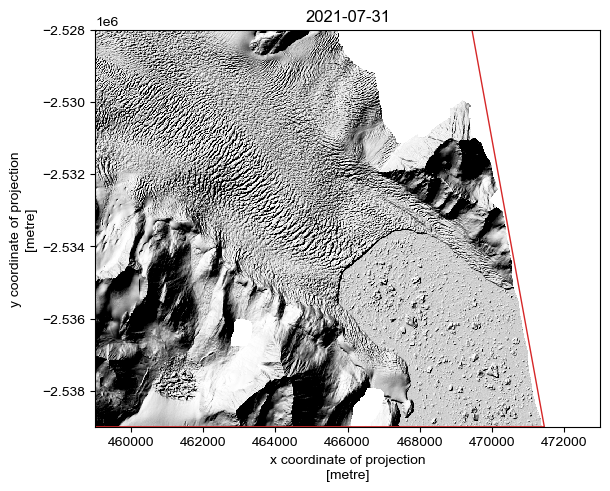

In [6]:

# =================
# SCENE TO PREVIEW
i = 4
# =================

preview = pdt.load.preview(gdf.iloc[[i]], bounds)

plt.close()
fig, ax = plt.subplots(layout='constrained')
preview.plot(cmap='Greys_r', add_colorbar=False)

gdf.iloc[[i]].plot(ax=ax, fc='none', ec='tab:red')

ax.set_title(gdf.iloc[[i]].acqdate1.values[0])


By examining the individual strips one-by-one, we can manually identify the optimal scenes for our purpose. Here, I have selected the second and fourth strips (index positions 1 and 4)

In [7]:
selected_scenes = [1, 4]

Let's save the selected scenes as a geopackage, so we can return to this later:

In [8]:
if not os.path.exists('example_data'):
    os.mkdir('example_data')

In [9]:
gdf_sel = gdf.iloc[selected_scenes]

gdf_sel.to_file('example_data/scenes.gpkg')

gdf_sel

,dem_id,pairname,stripdemid,sensor1,sensor2,catalogid1,catalogid2,acqdate1,acqdate2,gsd,...,avg_expect,avg_sunel1,avg_sunel2,rmse,fileurl,s3url,Shape_Leng,Shape_Area,geometry,dem_baseline_days
83476,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,WV01_20170624_1020010060B7D000_1020010063B5E200,WV01_20170624_1020010060B7D000_1020010063B5E20...,WV01,WV01,1020010060B7D000,1020010063B5E200,2017-06-24,2017-06-24,2.0,...,1.020010,42.000000,0.0,-9999.0,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,81506.304404,4.458097e+08,"POLYGON ((459000.000 -2539000.000, 459000.000 ...",0
277660,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,WV02_20210731_10300100C359CF00_10300100C37C8000,WV02_20210731_10300100C359CF00_10300100C37C800...,WV02,WV02,10300100C359CF00,10300100C37C8000,2021-07-31,2021-07-31,2.0,...,0.858702,41.629412,0.0,-9999.0,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,224106.736327,1.690805e+09,"POLYGON ((471450.480 -2539000.000, 459000.000 ...",0


# Downloading the strips

From the geopandas dataframe, we can extract key information such as the DEM ID and dates:

In [10]:
date_1 = gdf_sel.iloc[[0]].acqdate1.values[0]
dem_id_1 = gdf_sel.iloc[[0]].dem_id.values[0]

date_2 = gdf_sel.iloc[[1]].acqdate1.values[0]
dem_id_2 = gdf_sel.iloc[[1]].dem_id.values[0]


But we needn't do all this just to downlad a strip, as the `load.from_search()` function will accept a dataframe row directly. Let's make a little function to download and save the data - we can save the dem using the rioxarray accessor function `.rio.to_raster()`:

In [11]:
def download_scene(gdf_row, dem_id, output_directory='example_data'):
    
    dem = pdt.load.from_search(gdf_row, bounds=bounds, bitmask=True)
    
    dem.compute()  # rioxarray uses lazy evaluation, so we can force the download using the `.compute()` function.
    
    dem.rio.to_raster(os.path.join(output_directory, f'{dem_id}.tif'), compress='LZW')

    return dem

And now, we can select relevant rows from our geodataframe using the standard Pandax indexing method (`DataFrame.iloc[[i]]`, where `i` is the desired row index)

In [40]:

dem_1 = download_scene(gdf_sel.iloc[[0]], dem_id_1)


In [41]:

dem_2 = download_scene(gdf_sel.iloc[[1]], dem_id_2)


These are 2 m strips that will take a while to download! However, if you have saved them locally, as we have above, getting them back into the script without downloading is as simple as using the `load.from_fpath()` function:

In [12]:

dem_1 = pdt.load.from_fpath(os.path.join('example_data', f'{dem_id_1}.tif'), bounds=bounds)


In [13]:

dem_2 = pdt.load.from_fpath(os.path.join('example_data', f'{dem_id_2}.tif'), bounds=bounds)


Let's plot up one of the DEMs, taking advantage of the in-built hillshade generation function:

In [14]:
hillshade_1 = dem_1.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=2)

Text(0.5, 1.0, '2021-07-31')

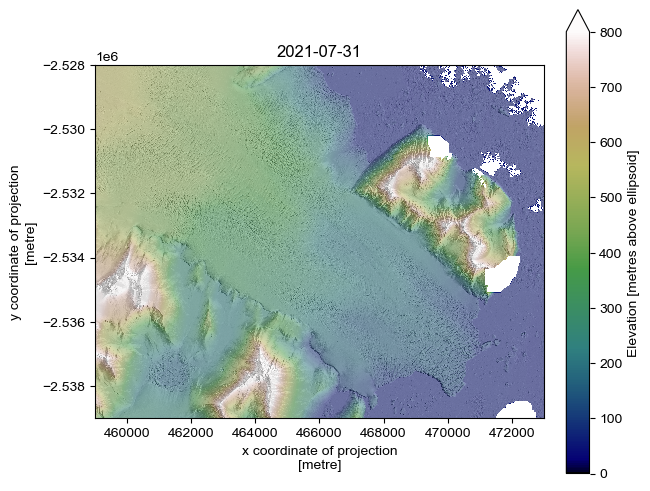

In [15]:
plt.close()
fig, ax = plt.subplots(layout='constrained')

dem_1.plot(cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})

hillshade_1.plot(cmap='Greys_r', alpha=.5, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(gdf.iloc[[i]].acqdate1.values[0])

# Coregistration and DEM differencing

Rigorous DEM differencing necessitates coregistering scenes. pDEMtools includes a couple functions to make this quick and easy - although it only provides one method of coregistration, that of Nuth and Kääb (2011). 

First, we must set a region of stable ground to coregister too. Around Antarctica and Greenland, we can base this on the mask included within BedMachine. The `data.bedrock_mask_from_bedmachine()` function makes this easy:

In [16]:
bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, dem_1)

Then we can coregister `dem_2` against `dem_1` using the `.pdt.coregister()` function. This is based off code used in the [PGC postprocessing pipeline](https://github.com/PolarGeospatialCenter/setsm_postprocessing_python/blob/fd36fd54933ec43f587902a4fdcd1acbd90951c2/lib/scenes2strips.py
).

In [17]:
dem_2_coreg = dem_2.pdt.coregister(dem_1, bedrock_mask)

Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 5.008943557739258
Planimetric Correction Iteration 2
Offset (z,x,y): -0.506, -5.149, -5.180
RMSE = 4.918196201324463
Planimetric Correction Iteration 3
Offset (z,x,y): -0.506, -10.298, -10.359
RMSE = 4.918196201324463
RMSE step in this iteration (0.00000) is above threshold (-0.001), stopping and returning values of prior iteration
Final offset (z,x,y): -0.506, -5.149, -5.180
Final RMSE = 4.918196201324463
Translating: -0.51 X, -5.15 Y, -5.18 Z
Translating in Z direction
Translating in XY direction.


Let's compare and plot:

In [18]:
dz_coreg = (dem_2_coreg - dem_1)

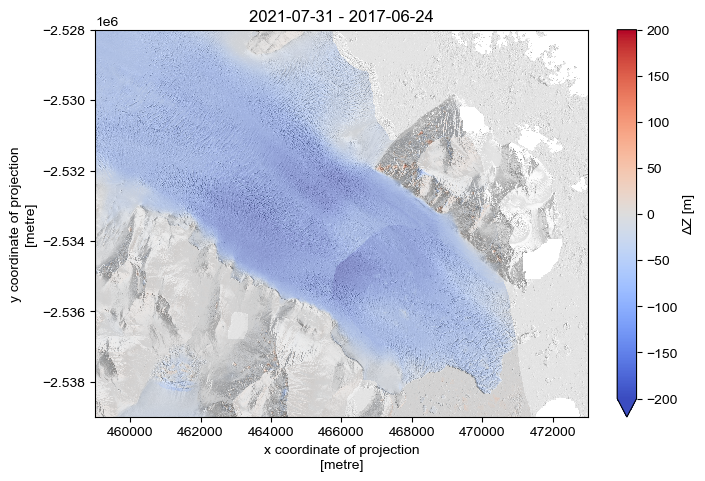

In [19]:
plt.close()
fig, ax = plt.subplots(layout='constrained', figsize=(7,4.7))

vrange = 200
dz_coreg.plot(cmap='coolwarm', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'ΔZ [m]'})
hillshade_1.plot(cmap='Greys_r', alpha=.5, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(f'{gdf_sel.iloc[[1]].acqdate1.values[0]} - {gdf_sel.iloc[[0]].acqdate1.values[0]}')

plt.savefig('../images/example_dem_difference.jpg', dpi=300)